### Overview of the patent owners for each disease

#### Import modules

In [1]:
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import string

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['figure.dpi'] = 400
sns.set(context='poster', style='dark')

### Loading data files

In [4]:
DATA_DIR = '../data/patent_dumps'
FIG_DIR = '../data/figures'

In [5]:
rare_disease_data = pd.read_csv(f'{DATA_DIR}/orphanet_normalized_patent_data.tsv', sep='\t')
rare_disease_data.head(2)

,chembl,surechembl,patent_id,date,ipc,assignee,organization_name,acquired_by,person
0,CHEMBL3137316,SCHEMBL1707427,US-20140316139-A1,2014-10-23,C07D 213/89,PFIZER,Pfizer,NaN,NaN
1,CHEMBL3137316,SCHEMBL1707427,US-20140142316-A1,2014-05-22,C07D 213/89,PFIZER,Pfizer,NaN,NaN


In [6]:
alzheimer_disease_data = pd.read_csv(f'{DATA_DIR}/ad_normalized_patent_data.tsv', sep='\t')
alzheimer_disease_data.head(2)

,chembl,surechembl,patent_id,date,ipc,assignee,organization_name,acquired_by,person
0,CHEMBL1460470,SCHEMBL14919618,US-20140256767-A1,2014-09-11,C07D 401/14,UNIV RUTGERS,Rutgers University,NaN,NaN
1,CHEMBL1460470,SCHEMBL14919618,US-20180148408-A1,2018-05-31,C07D 209/48,UNIV RUTGERS,Rutgers University,NaN,NaN


Drop patents with no assignee names

In [7]:
rare_disease_data.shape, alzheimer_disease_data.shape

((17506, 9), (76321, 9))

In [8]:
rare_disease_data = rare_disease_data[~rare_disease_data['assignee'].isna()]
rare_disease_data.shape

(17375, 9)

In [9]:
alzheimer_disease_data = alzheimer_disease_data[~alzheimer_disease_data['assignee'].isna()]
alzheimer_disease_data.shape

(75616, 9)

Count of each category

In [10]:
def get_assignee_category_count(df: pd.DataFrame):
    """Get dataframe with count of high-level assignee classification"""
    
    assignee_dict = defaultdict(set)
    
    for patent_idx, org, is_aquired, person_name in tqdm(
        df[['patent_id', 'organization_name', 'acquired_by', 'person']].values
    ):

        if pd.notna(is_aquired):
            assignee_dict['acquired'].add(patent_idx)
        elif pd.notna(person_name):
            assignee_dict['individuals'].add(patent_idx)
        else:
            assert pd.notna(org), f"Some discepancy found in {patent_idx}!"
            assignee_dict['organisation'].add(patent_idx)
    
    assignee_dict = [
        {
            'assignee_type': assignee_type,
            'patent_count': len(patents)
        }
        for assignee_type, patents in assignee_dict.items()
    ]
    
    return pd.DataFrame(assignee_dict)

In [11]:
get_assignee_category_count(rare_disease_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17375/17375 [00:00<00:00, 361827.47it/s]


,assignee_type,patent_count
0,organisation,369
1,individuals,53
2,acquired,80


In [12]:
get_assignee_category_count(alzheimer_disease_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75616/75616 [00:00<00:00, 320337.44it/s]


,assignee_type,patent_count
0,organisation,10017
1,individuals,1778
2,acquired,1386


### Overall historic perspective

In [13]:
def get_historic_view(df: pd.DataFrame):
    """Create dataframe with patents filed per year."""
    
    year_dict = defaultdict(lambda: defaultdict(set))
    
    for patent_idx, date, org, is_aquired, is_person in tqdm(
        df[['patent_id', 'date', 'organization_name', 'acquired_by', 'person']].values
    ):
        year = date.split('-')[0]
        
        if pd.notna(is_person):
            assignee_type = 'individuals'
        elif pd.notna(is_aquired):
            assignee_type = 'acquired'
        else:
            assignee_type = 'organisations'
        
        year_dict[int(year)][assignee_type].add(patent_idx)
    
    year_dict = [
        {
            'year': year,
            'Organisation': len(assignee_dict['organisations']) if 'organisations' in assignee_dict else 0,
            'Individuals': len(assignee_dict['individuals']) if 'individuals' in assignee_dict else 0,
            'Acquired': len(assignee_dict['acquired']) if 'acquired' in assignee_dict else 0,
        }
        
        for year, assignee_dict in year_dict.items()
    ]
    
    return pd.DataFrame(year_dict)
    

In [14]:
rare_disease_year_df = get_historic_view(rare_disease_data)
rare_disease_year_df.sort_values(by='year', inplace=True)
rare_disease_year_df.head(2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17375/17375 [00:00<00:00, 291015.22it/s]


,year,Organisation,Individuals,Acquired
21,2000,6,0,1
15,2001,9,0,0


In [15]:
alzheimer_disease_year_df = get_historic_view(alzheimer_disease_data)
alzheimer_disease_year_df.sort_values(by='year', inplace=True)
alzheimer_disease_year_df.head(2)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75616/75616 [00:00<00:00, 306921.58it/s]


,year,Organisation,Individuals,Acquired
14,2000,150,3,48
12,2001,189,8,48


Visualisation

<Figure size 6000x4000 with 0 Axes>

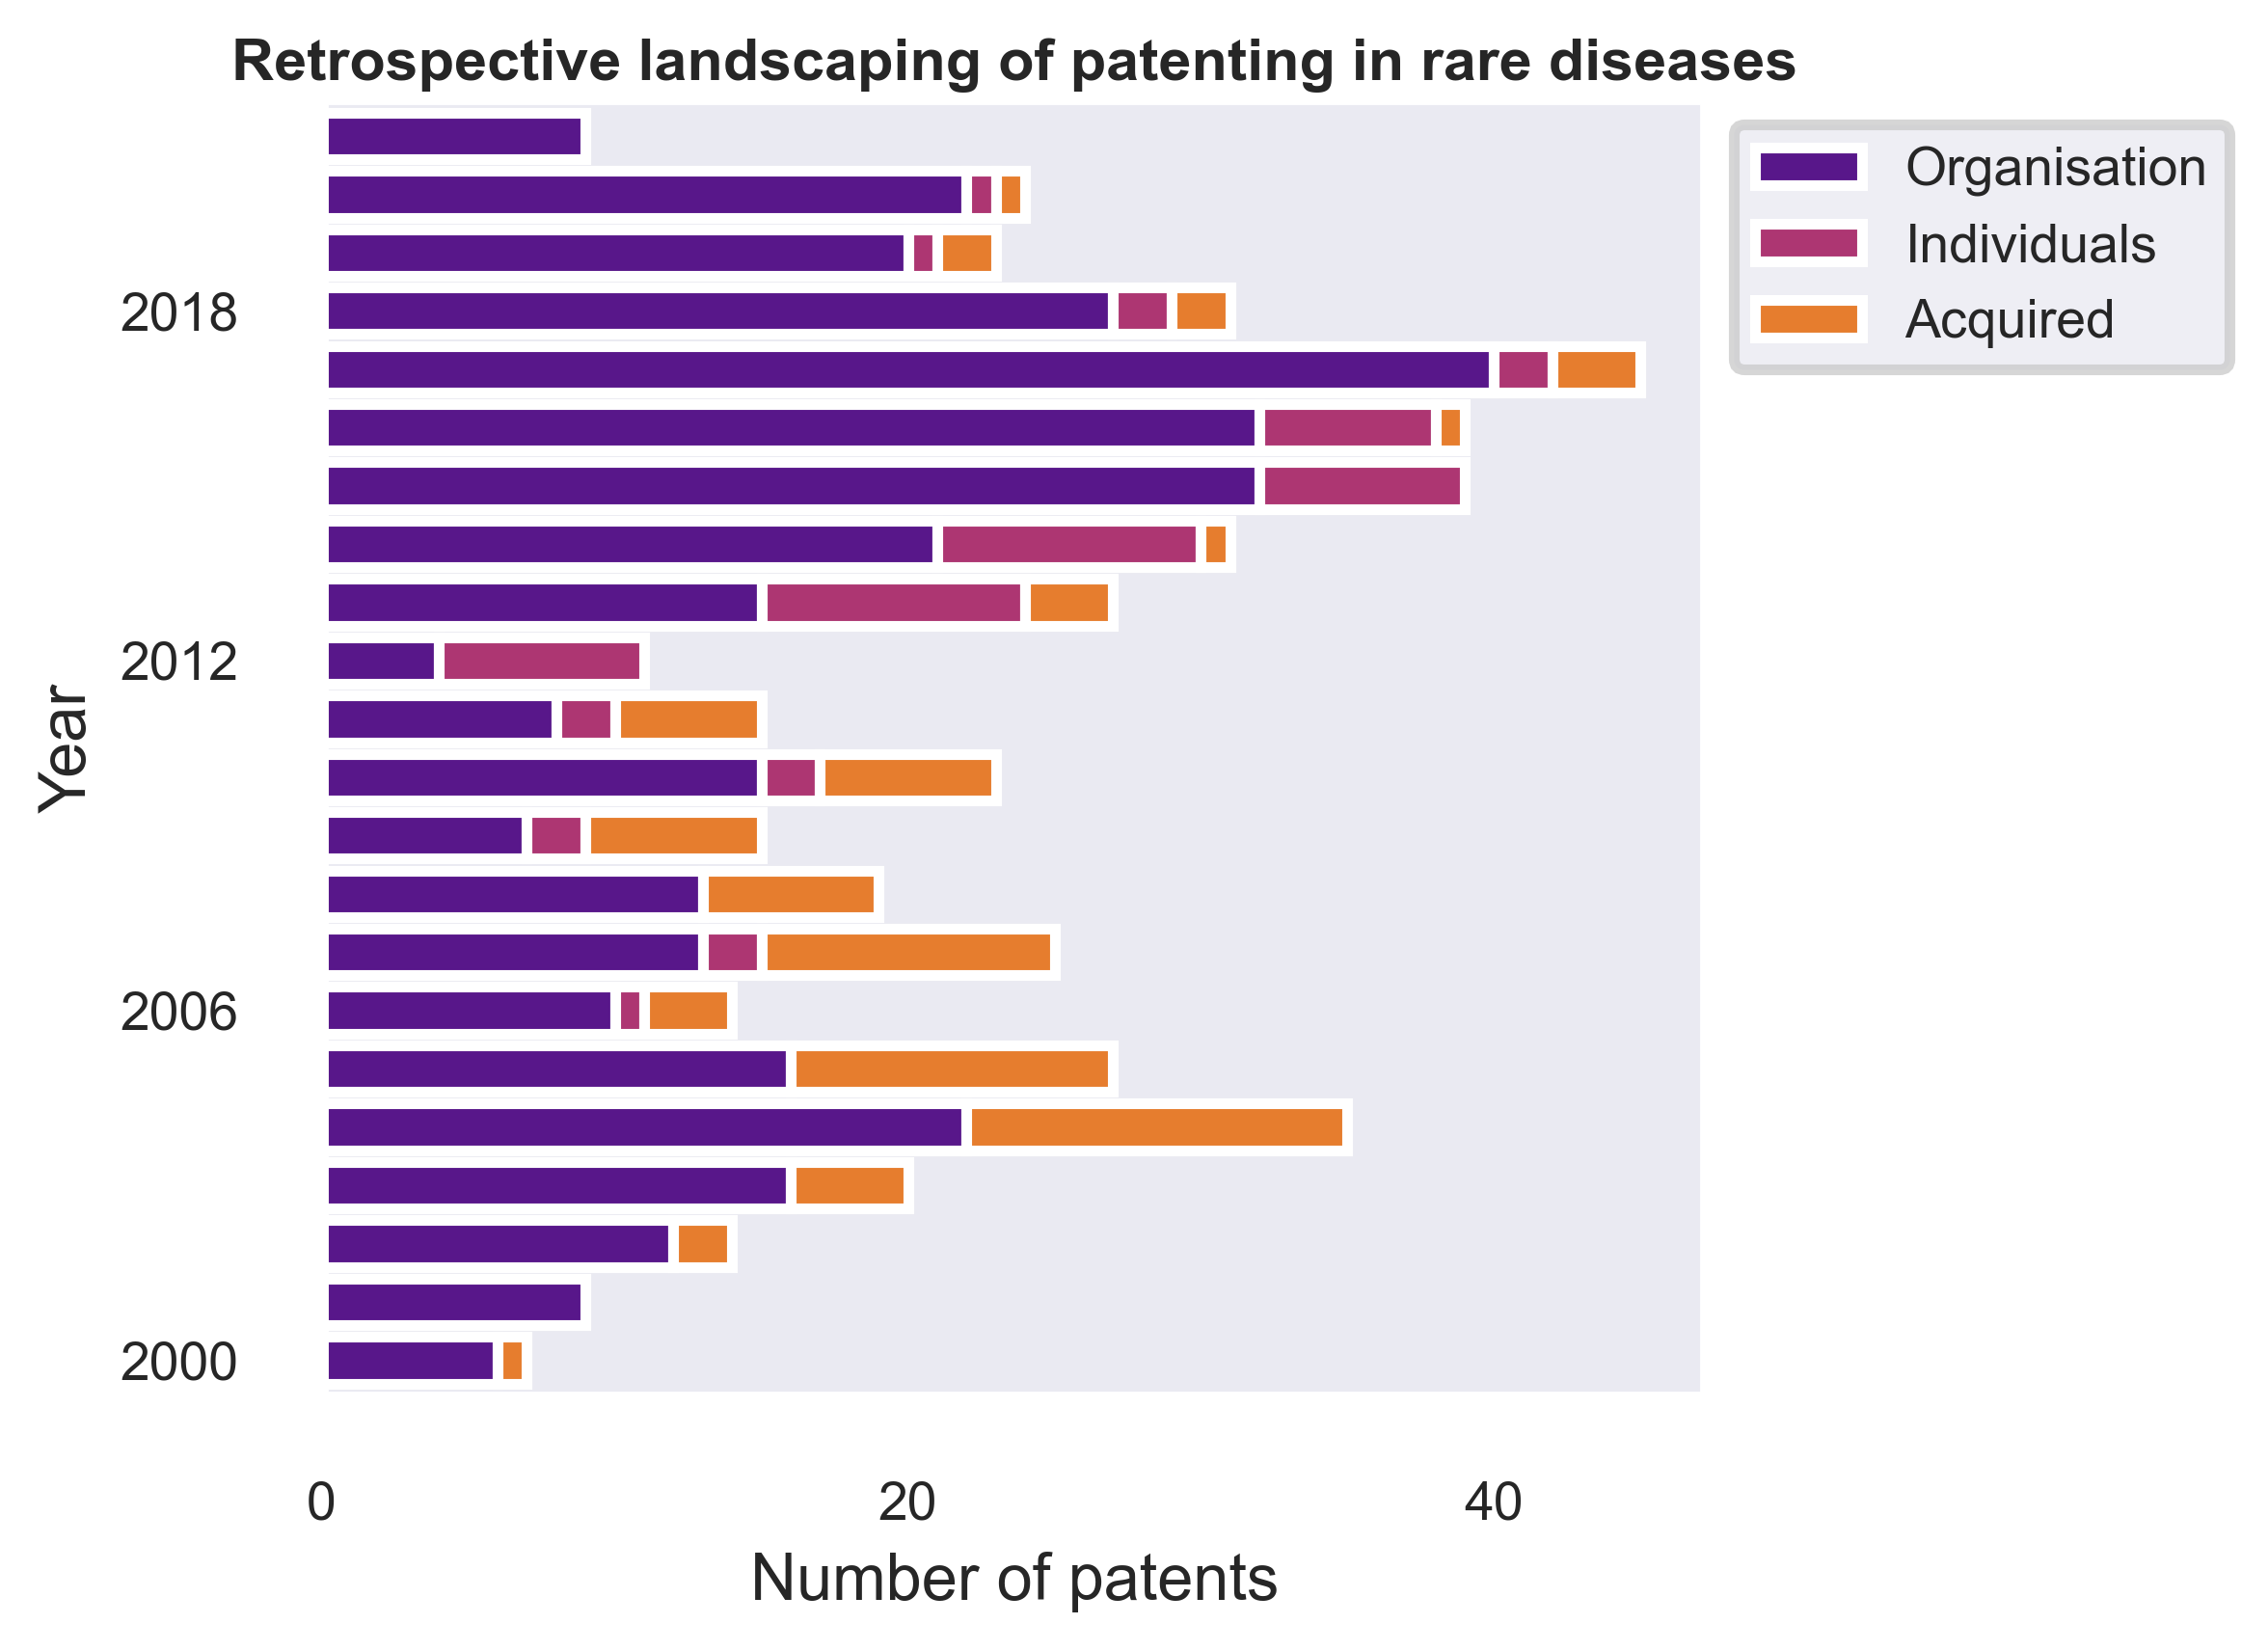

In [16]:
plt.figure(figsize=(15, 10))
rare_disease_year_df.plot.barh(x='year', stacked=True, color=['#58178a', '#ad3672', '#e67d2e'], width=0.8,)
plt.title(
    'Retrospective landscaping of patenting in rare diseases', 
    horizontalalignment='center', size=11,
    verticalalignment='center', weight='bold'
)
plt.xlabel('Number of patents', size=12)
plt.ylabel('Year', size=12)
plt.locator_params(axis='both', nbins=4)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(1, 1), prop={'size': 10})
plt.tight_layout()

plt.savefig(
    f'{FIG_DIR}/figure_3.png',
    dpi=400,
    bbox_inches='tight', 
)

plt.show()

<Figure size 6000x4000 with 0 Axes>

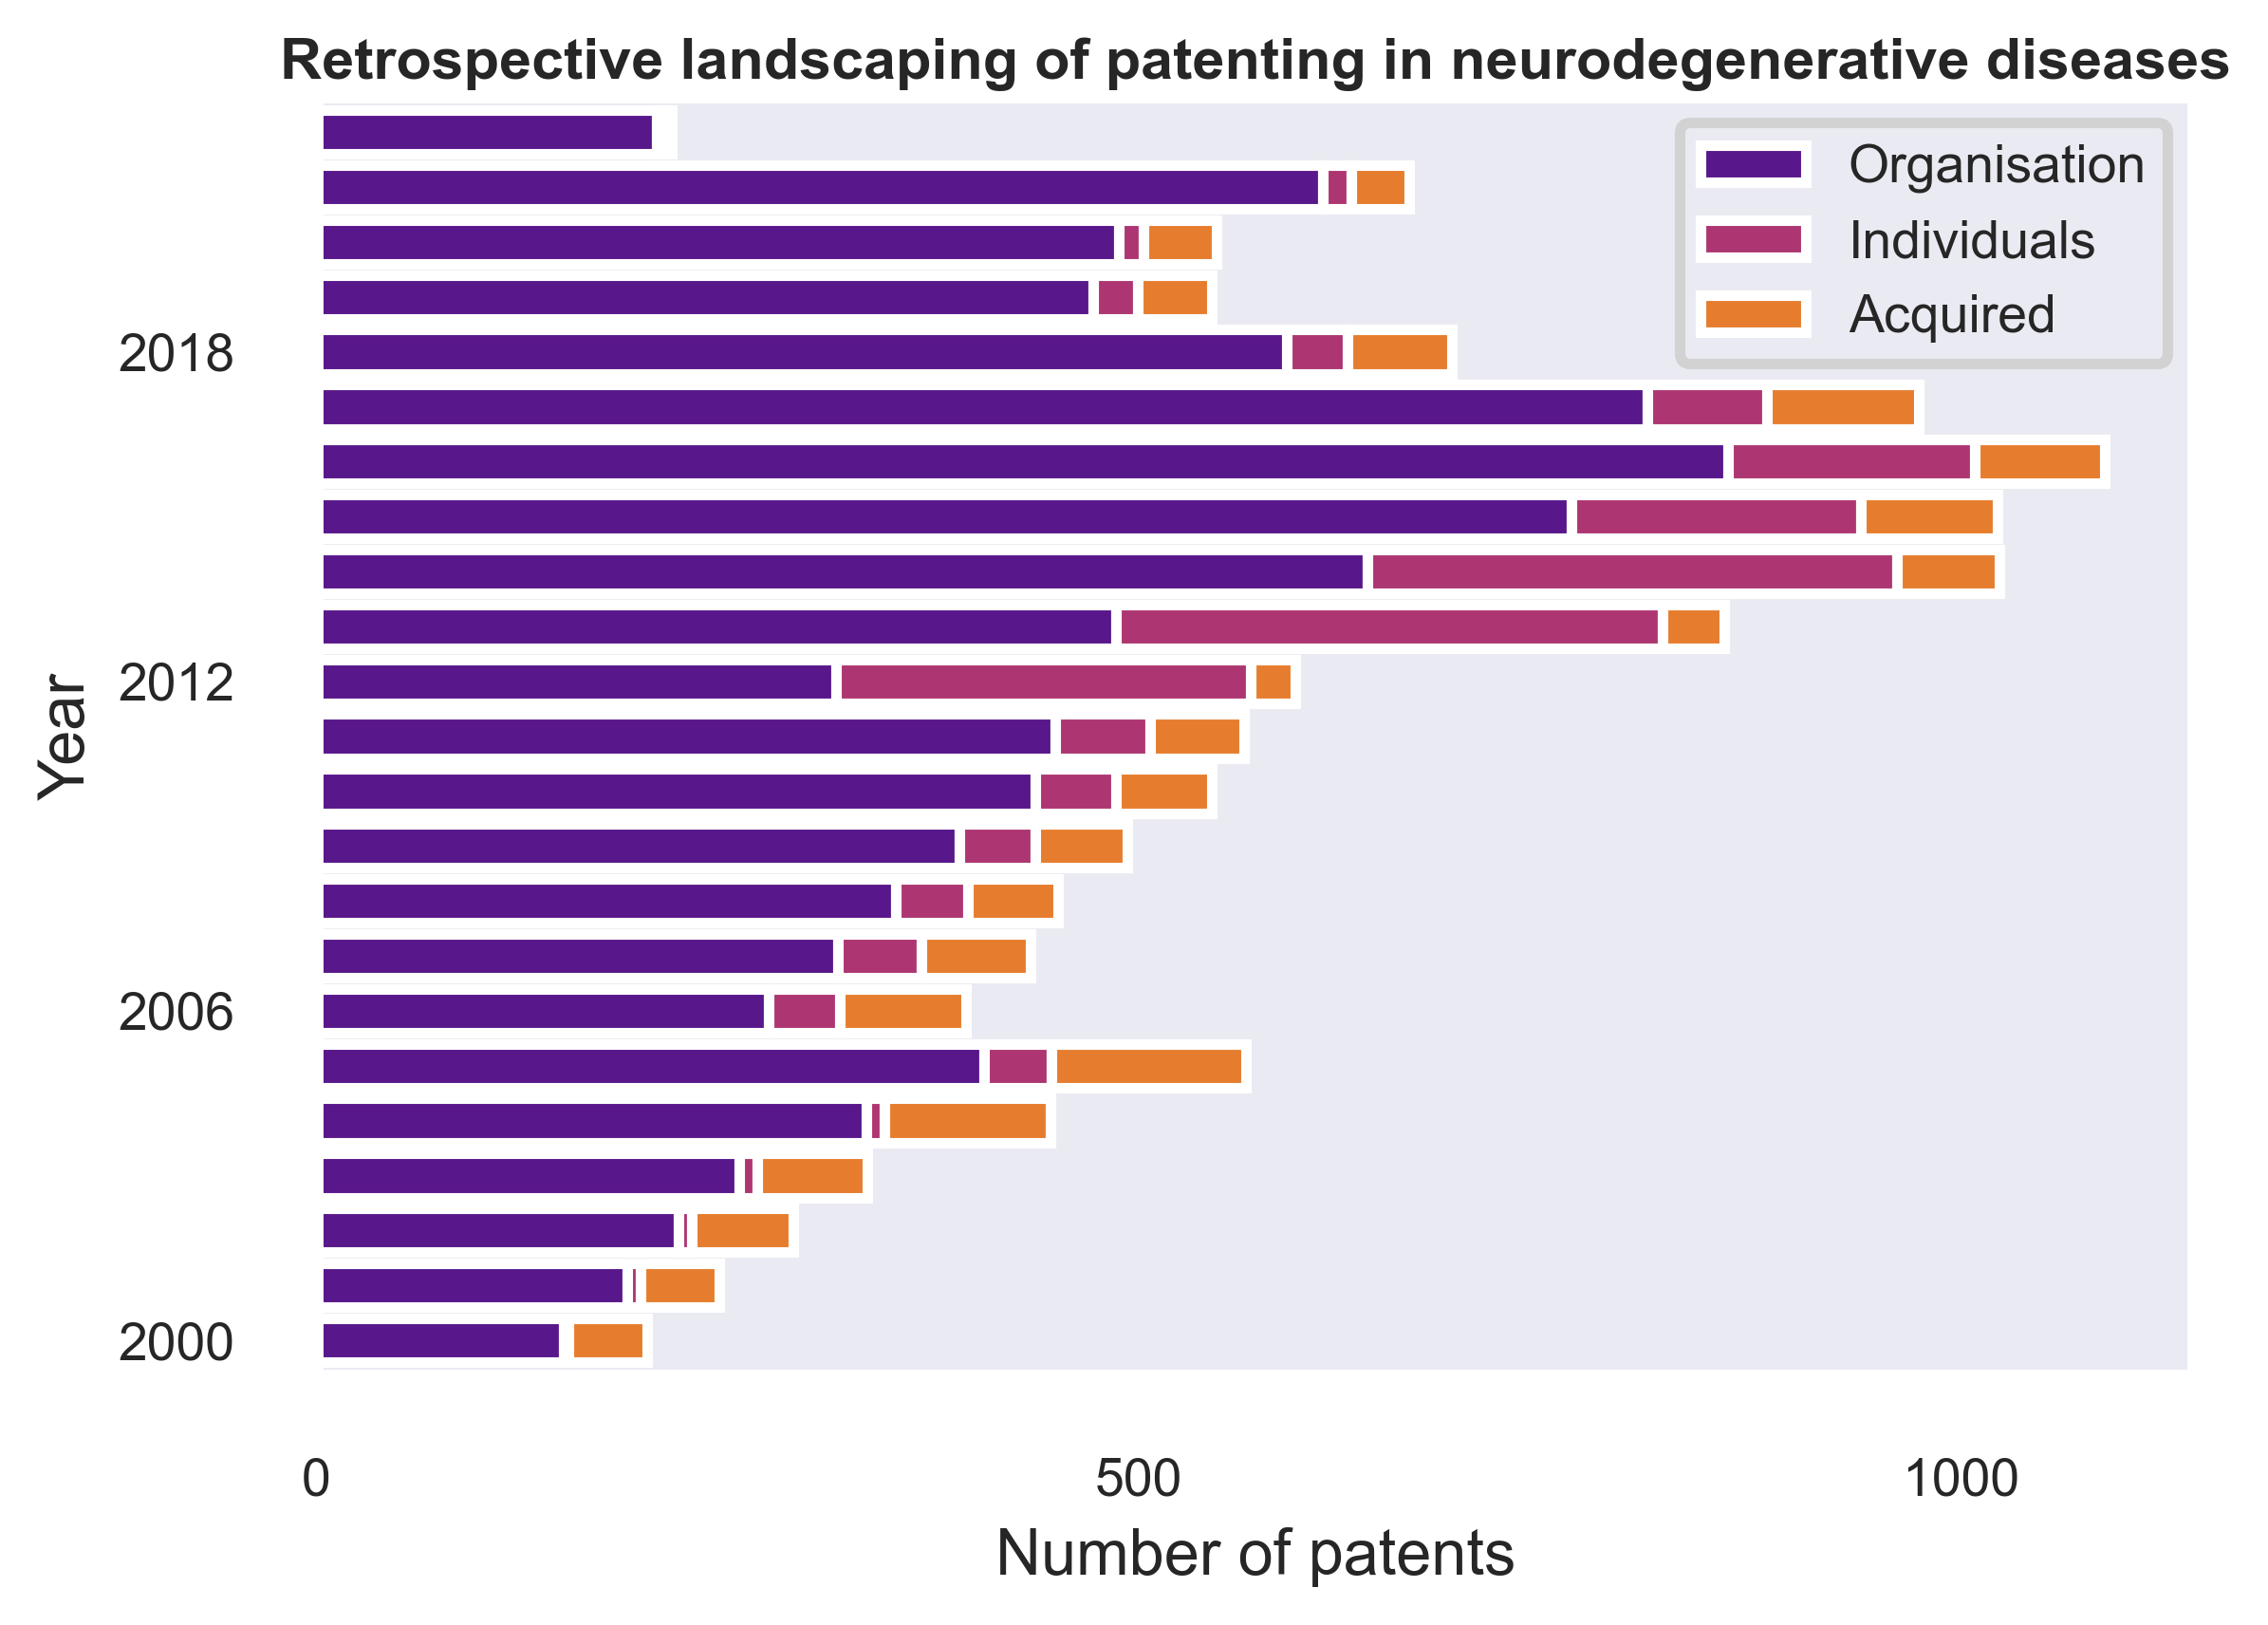

In [17]:
plt.figure(figsize=(15, 10))
alzheimer_disease_year_df.plot.barh(x='year', stacked=True, color=['#58178a', '#ad3672', '#e67d2e'], width=0.8,)
plt.title(
    'Retrospective landscaping of patenting in neurodegenerative diseases', 
    horizontalalignment='center', size=11,
    verticalalignment='center', weight='bold'
)
plt.xlabel('Number of patents', size=12)
plt.ylabel('Year', size=12)
plt.locator_params(axis='both', nbins=4)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(bbox_to_anchor=(1, 1), prop={'size': 10})
plt.tight_layout()

plt.savefig(
    f'{FIG_DIR}/figure_5.png',
    dpi=400,
    bbox_inches='tight', 
)

plt.show()

### Historic perspective of top 10 assignees

Patent document based assignee ranking 

In [18]:
def create_assignee_rank(df: pd.DataFrame):
    """Create assignee dataframe based on the no.of patent documents contributed."""
    
    assignee_dict = defaultdict(set)
    patent_dict = defaultdict(lambda: defaultdict(set))
    
    for patent_idx, date, assignee, org, is_aquired, person_name in tqdm(
        df[['patent_id', 'date', 'assignee', 'organization_name', 'acquired_by', 'person']].values
    ):
        year = date.split("-")[0]
        
        if pd.notna(is_aquired):
            assignee_dict['acquired'].add(is_aquired)
            patent_dict[is_aquired][year].add(patent_idx)
        elif pd.notna(person_name):
            assignee_dict['individuals'].add(assignee)
            patent_dict[assignee][year].add(patent_idx)
        else:
            assert pd.notna(org), f"Some discepancy found in {patent_idx}!"
            assignee_dict['organisation'].add(org)
            patent_dict[org][year].add(patent_idx)
        
    patent_data = []
    for assignee_name, year_based_dict in patent_dict.items():
        if assignee_name in assignee_dict['organisation']:
            assignee_type = 'organisation'
        elif assignee_name in assignee_dict['acquired']:
            assignee_type = 'acquired'
        else:
            assert assignee_name in assignee_dict['individuals'], f"{assignee_name} not found!"
            assignee_type = 'individuals'
        
        # Get total patent count
        all_patents = set()
        for patents in year_based_dict.values():
            all_patents.update(patents)
        
        for year, year_patents in year_based_dict.items():
            patent_data.append({
                'assignee_name': assignee_name,
                'total_patent_count': len(all_patents),
                'assignee_type': assignee_type,
                'year': int(year),
                'annual_patent_count': len(year_patents)
            })
        
    return pd.DataFrame(patent_data)

In [19]:
rare_disease_assignee_rank = create_assignee_rank(rare_disease_data)
rare_disease_assignee_rank.sort_values(
    by=['total_patent_count', 'year'], ascending=[False, True], inplace=True
)
rare_disease_assignee_rank.head(1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17375/17375 [00:00<00:00, 308154.32it/s]


,assignee_name,total_patent_count,assignee_type,year,annual_patent_count
6,Pfizer,48,organisation,2000,2


In [20]:
# Get top 10 assignees and sort by year
top_10_rare_disease_assignee = rare_disease_assignee_rank[
    'assignee_name'
].value_counts().head(10).index.to_list()

top_assignee_rare_disease = rare_disease_assignee_rank[
    rare_disease_assignee_rank['assignee_name'].isin(top_10_rare_disease_assignee)
]

In [21]:
alzheimers_disease_assignee_rank = create_assignee_rank(alzheimer_disease_data)
alzheimers_disease_assignee_rank.sort_values(
     by=['total_patent_count', 'year'], ascending=[False, True], inplace=True
)
alzheimers_disease_assignee_rank.head(1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75616/75616 [00:00<00:00, 261513.05it/s]


,assignee_name,total_patent_count,assignee_type,year,annual_patent_count
332,Pfizer,552,organisation,2000,7


In [22]:
# Get top 10 assignees and sort by year

top_10_alzheimer_disease_assignee = alzheimers_disease_assignee_rank[
    'assignee_name'
].value_counts().head(10).index.to_list()

top_assignee_alzheimers_disease = alzheimers_disease_assignee_rank[
    alzheimers_disease_assignee_rank['assignee_name'].isin(top_10_alzheimer_disease_assignee)
]

Visualisation

In [23]:
def create_assignee_plot(df: pd.DataFrame, fig_num: str):
    g = sns.FacetGrid(
        df, col='assignee_name', hue='assignee_name', col_wrap=2,
        aspect=2.5, palette='tab10'
    )

    g = g.map(plt.plot, 'year', 'annual_patent_count')

    # Fill the area with fill_between
    g = g.map(
        plt.fill_between, 'year', 'annual_patent_count', alpha=0.2
    )

    # Control the title of each facet
    g.set_titles("{col_name}")


    # Add a title for the whole plot
    plt.subplots_adjust(top=0.5)

    for i, ax in enumerate(g.axes):
        ax.set_xlabel('Year')
        if i == 4:
            ax.set_ylabel('Patent count')
        else:
            ax.set_ylabel('')
        inventor_name = ax.get_title()
        patent_count = df[df['assignee_name'] == inventor_name]['total_patent_count'].unique().tolist()[0]
        ax.set_title(f'{inventor_name} ({patent_count} patents)')
        ax.grid(False)

    g = g.fig.suptitle(
        'Evolution of the patents in top 10 patent inventors',
        horizontalalignment='center',
        verticalalignment='center', weight='bold'
    )
    
    plt.tight_layout()
    plt.savefig(
        f'{FIG_DIR}/figure_{fig_num}.png',
        dpi=400,
        bbox_inches='tight', 
    )

    plt.show()

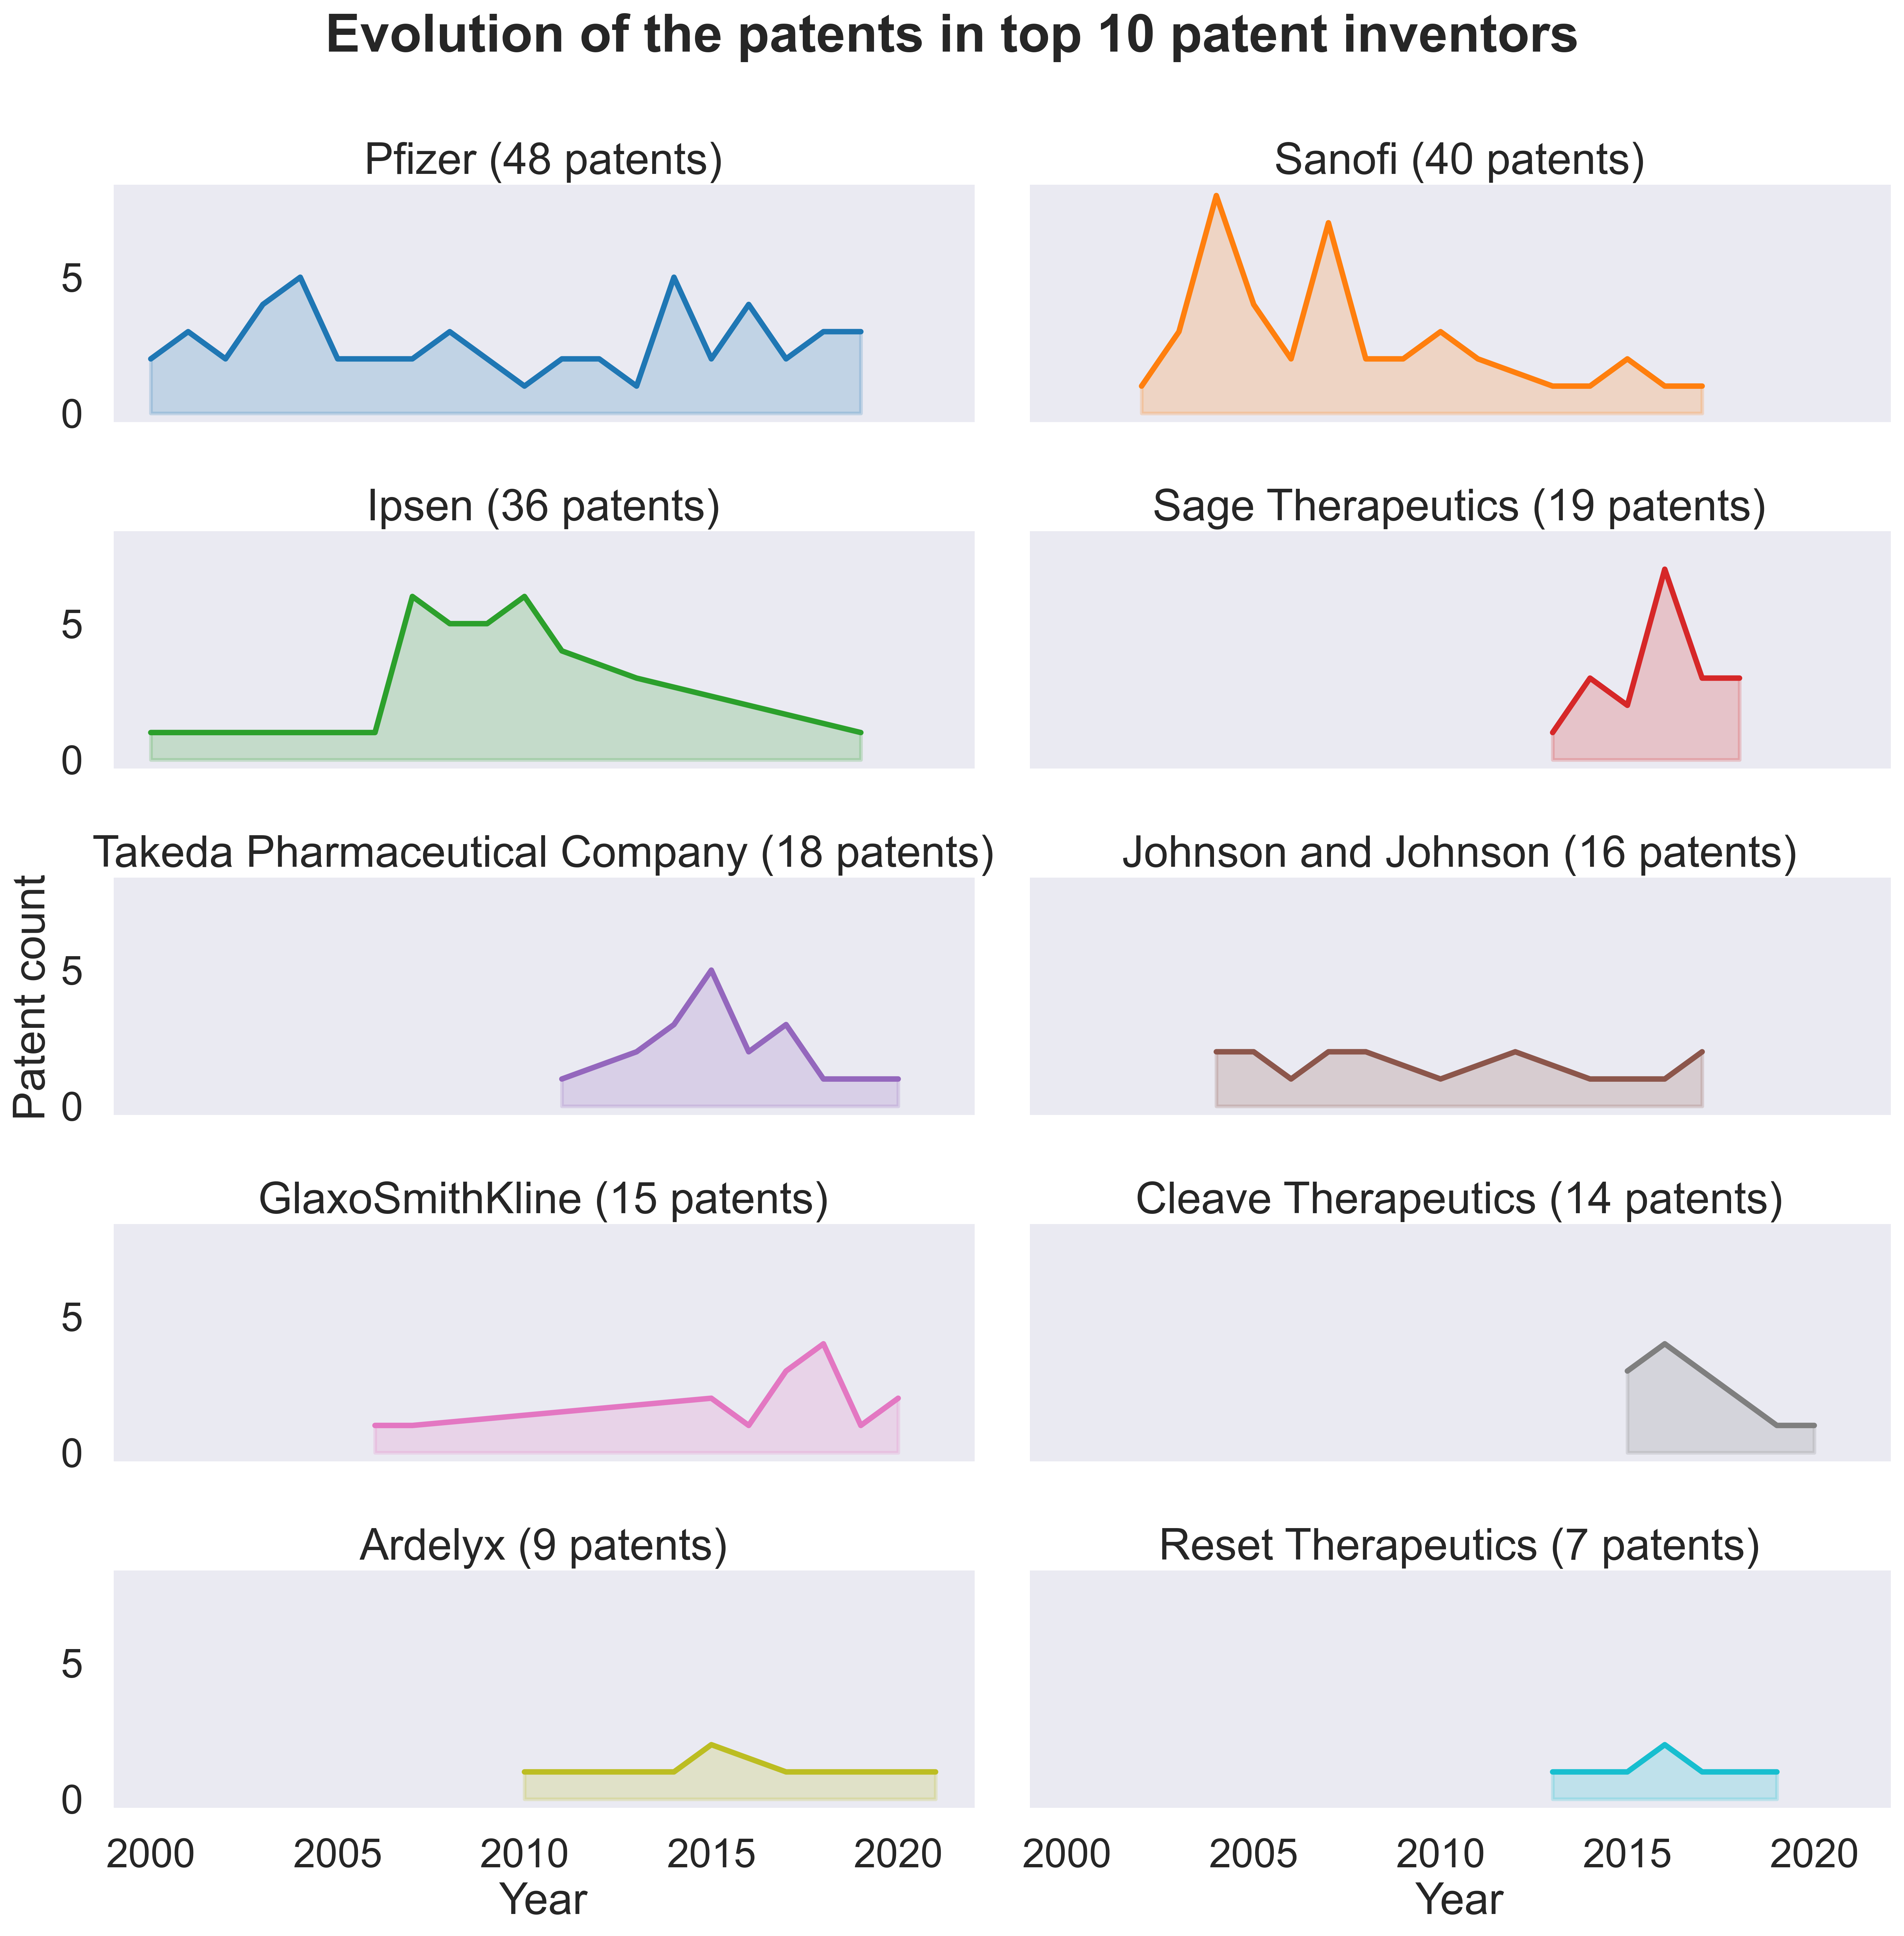

In [24]:
create_assignee_plot(top_assignee_rare_disease, '4')

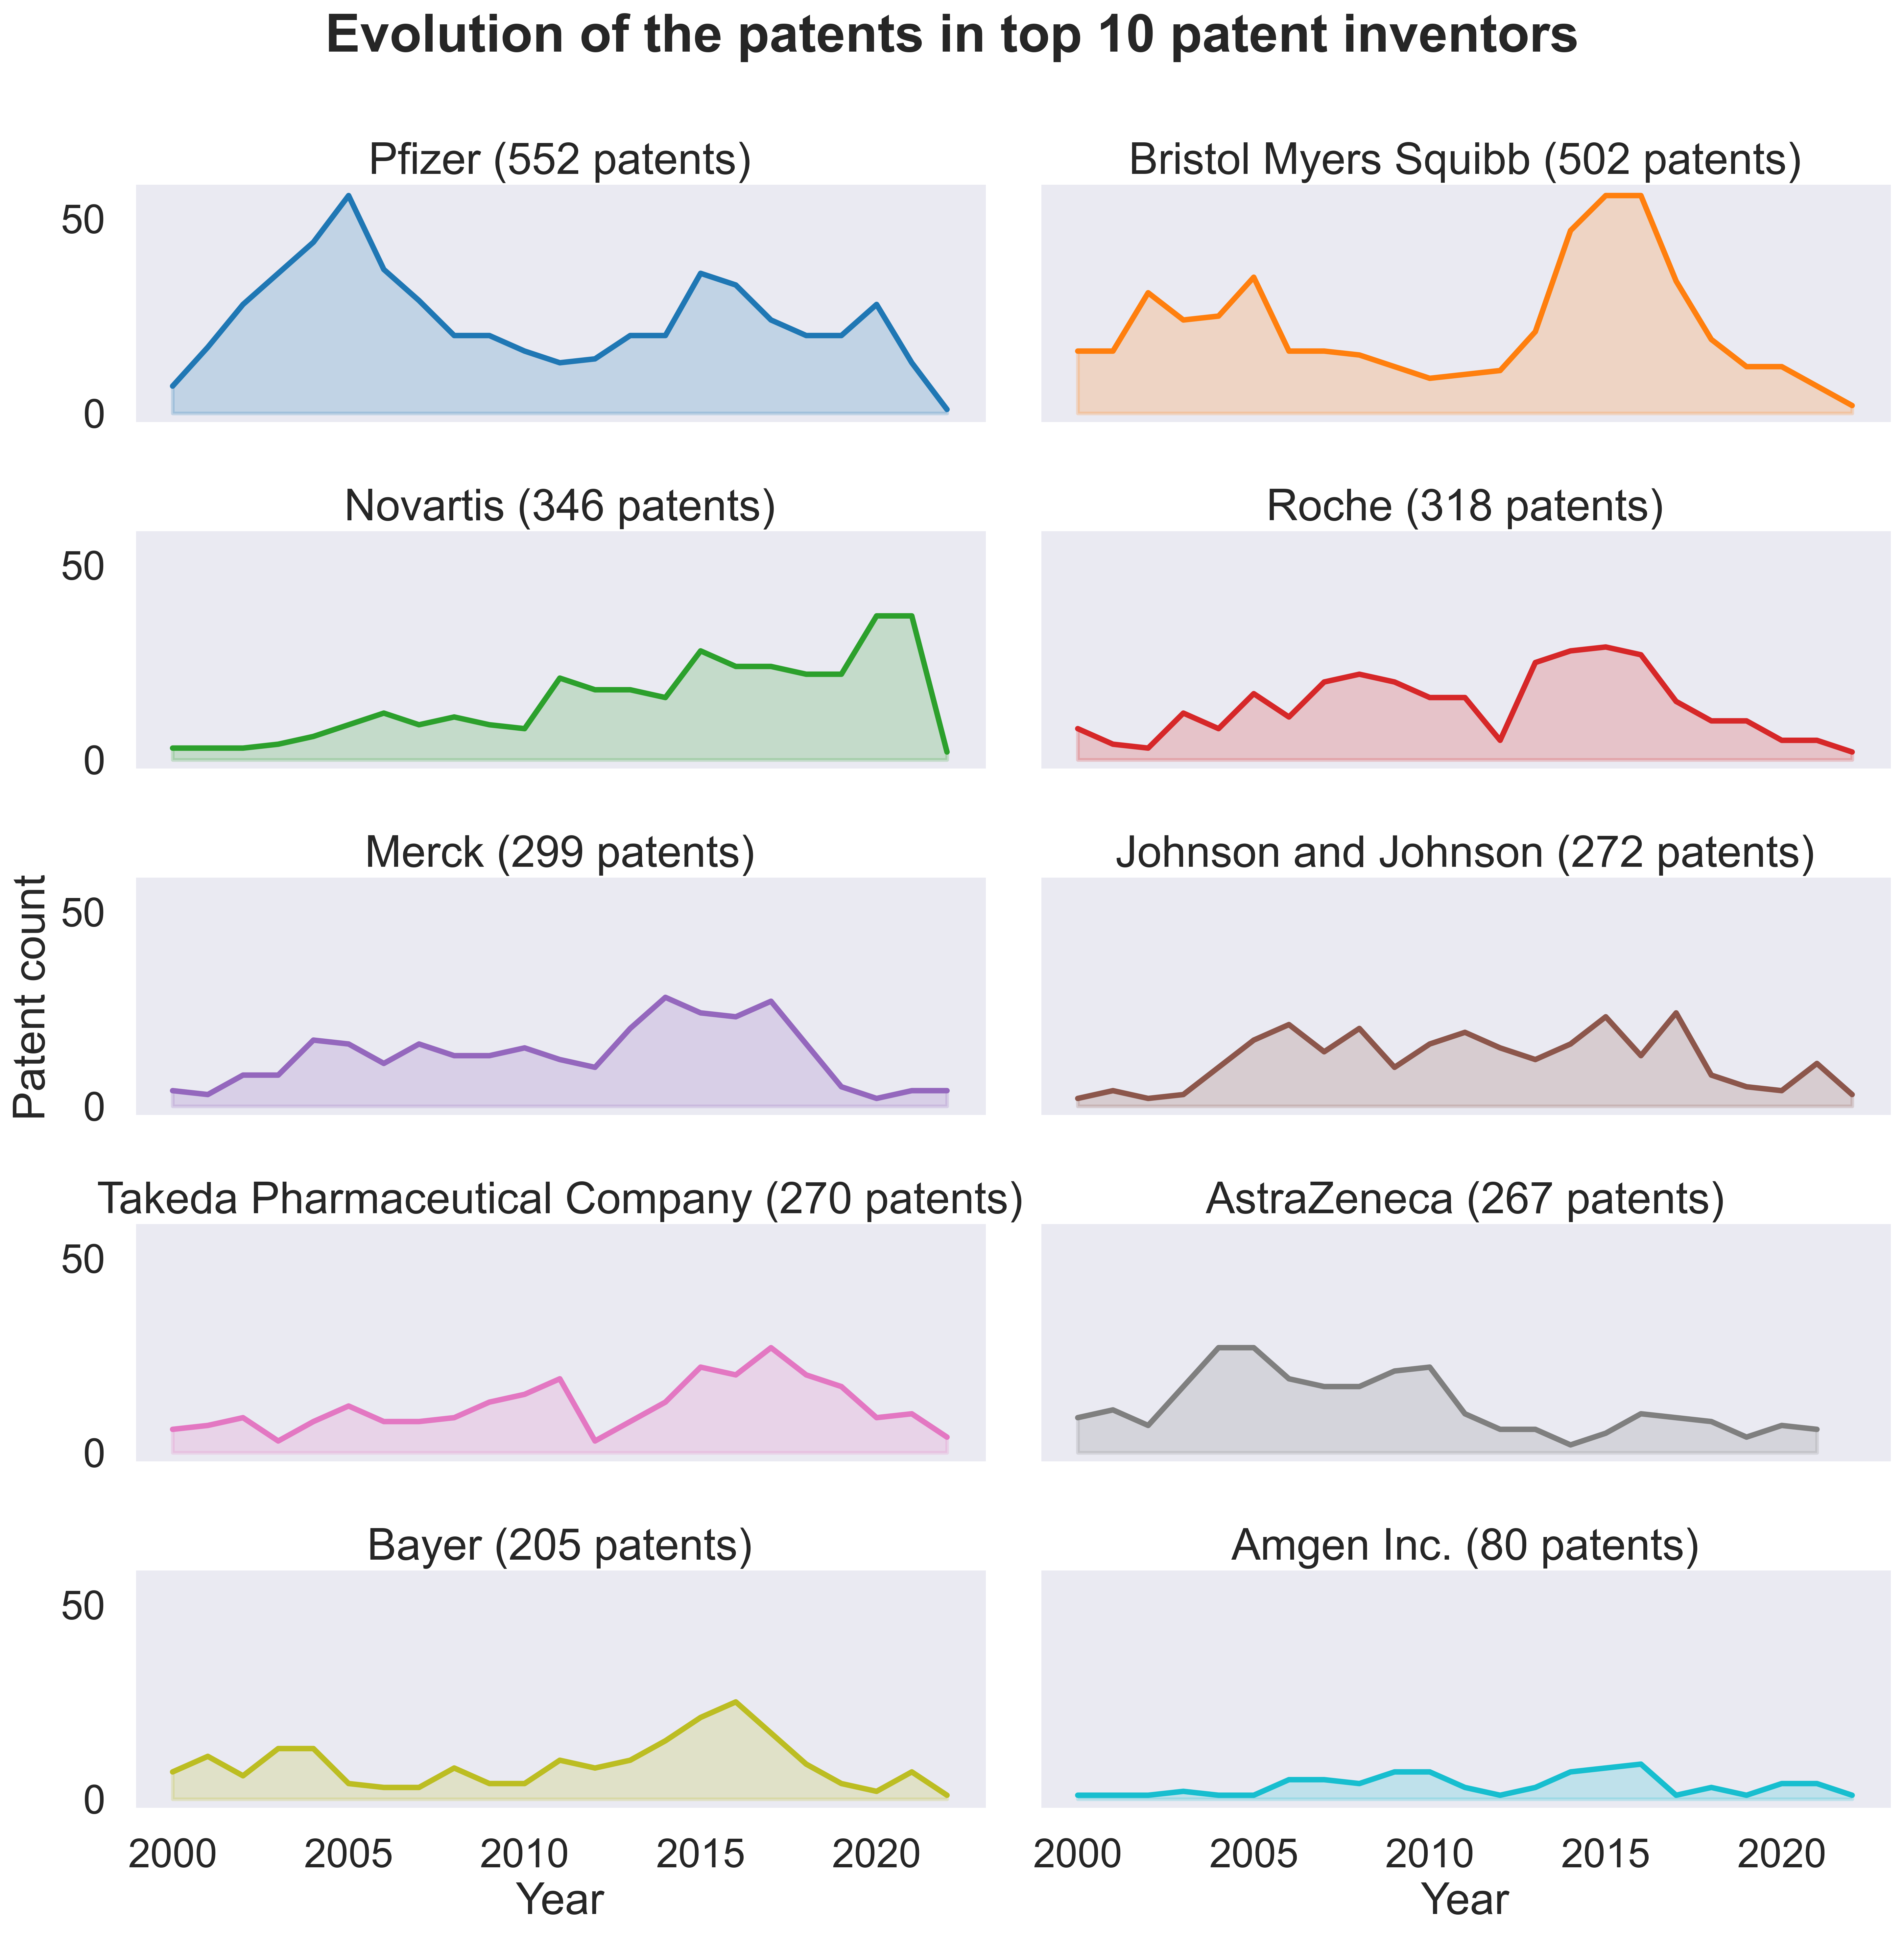

In [25]:
create_assignee_plot(top_assignee_alzheimers_disease, '6')